Данные содержат тренировочную (ranking_train.jsonl) и тестовую (ranking_test.jsonl) выборки.

В каждом файле почти одинаковый формат:
- Отдельная строчка в файле — валидный JSON с семплом
- Каждый JSON имеет поле text с текстом поста и массив сomments из 5 элементов
- Каждый элемент массива это словарь с ключами text с текстом комментария и score с позицией ранжирования (0 cоответствует самому популярному комментарию, 4 самому непопулярному)
- В тестовом файле в поле score стоит null

Заполните тестовую выборку, т.е. расставьте в файле ranking_test.jsonl вместо null значения score. В рамках одного семпла они должны быть от 0 до 4 и не должны повторяться.
Пришлите файл с результатами вместе с кодом и презентацией.

По валидации - будем смотреть на NDCG метрику (hint: она уже есть в библиотеке sklearn). 
В целом, хочется видеть рассуждения, поэтому можно предлагать и другие способы оценки.

# Подключение библиотек

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pandas as pd
import json
!pip install "sagemaker>=2.48.0"  --upgrade
import sagemaker.huggingface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.1/135.1 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.2 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.140.0-py2.py3-none-any.whl size=925364 sha256=5bcd0a6412824b6b62a8336a91641d5e5b1e84a28d2ac80cdd60c4143a968ed4
  Stored in

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sklearn as sk

# Подключение к google disk

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ranking_test = pd.read_json('/content/drive/MyDrive/Hack_DS/ranking_test.jsonl', lines=True, convert_dates=False, orient='columns') #вау считали джсон
ranking_test.head()

,text,comments
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",[{'text': 'I&#x27;m still waiting for them to ...
1,Ask HN: How do US HNers get their health insur...,[{'text': 'Get it from your employer. It&#x27;...
2,San Diego Researcher Crowdfunding Patent-Free ...,[{'text': 'What I don&#x27;t understand is why...
3,Rethinking the origins of the universe,[{'text': 'I&#x27;m not a physicist. I imagin...
4,SlackTextViewController: A new growing text in...,[{'text': 'As someone that doesn&#x27;t do iOS...


In [ ]:
ranking_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      14004 non-null  object
 1   comments  14004 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [ ]:
ranking_test['comments']

0        [{'text': 'I&#x27;m still waiting for them to ...
1        [{'text': 'Get it from your employer. It&#x27;...
2        [{'text': 'What I don&#x27;t understand is why...
3        [{'text': 'I&#x27;m not a physicist.  I imagin...
4        [{'text': 'As someone that doesn&#x27;t do iOS...
                               ...                        
13999    [{'text': 'Meanwhile in the US, Stubbs has bee...
14000    [{'text': 'A radical idea: Maybe our model of ...
14001    [{'text': 'Was the presentation more in-depth ...
14002    [{'text': 'Ok now I want to &quot;hear&quot; o...
14003    [{'text': 'I send a LOT of emails each month (...
Name: comments, Length: 14004, dtype: object

# Работа с ranking_train

In [7]:
ranking_train = pd.read_json('/content/drive/MyDrive/Hack_DS/ranking_train.jsonl', lines=True, convert_dates=False) #вау считали уже другой джсон
ranking_train.head()

,text,comments
0,How many summer Y Combinator fundees decided n...,[{'text': 'Going back to school is not identic...
1,CBS acquires last.fm for $280m,[{'text': 'It will be curious to see where thi...
2,How Costco Became the Anti-Wal-Mart,[{'text': 'I really hate it when people falsel...
3,"Fortune Favors Big Turds | Screw The Money, Th...",[{'text': 'His real point is that something ca...
4,StartupWeekend: 70 Founders Create One Company...,[{'text': 'Looks like someone hasn't read The ...


удаляем стоп-слова

In [8]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
print(stop_words) #вывели стоп-слова

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
nltk.download('punkt')
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Жесткий кодинг

Функция разделения текста на ключевые слова:

In [ ]:
from pandas.core.frame import rewrite_axis_style_signature
def only_words(index: int, key: str, ranking_train, comment_index = 0):
  import re
  line = ranking_train.iloc[index]
  if(key == 'text'):
    text = line['text']

  elif(key == 'comments'):
   # print(line)
    text = line['comments'][comment_index]['text']
  elif(key == 'score'):
    return line['comments'][comment_index]['score']
  #print(text)
  rew = re.sub(re.compile('[^A-Za-z]+'), ' ', text) #оставляем только слова в посте
  #print(rew)
  rew = rew.lower() #все делаем нижнего регистра
  #print(rew)
  rew = nltk.word_tokenize(rew) #разбили предложения на токены
  #print(rew)
  lemmatize = nltk.WordNetLemmatizer()
  rew = [lemmatize.lemmatize(word) for word in rew]
  rew = [word for word in rew if( word not in stop_words and len(word)>=3)] #удалили стоп-слова
  
  return rew
# only_words(5, 'comments', 1)

In [ ]:
changed_rt = pd.DataFrame({"text":[],"comments":[]})
for i in range(len(ranking_train)):
  
  #new_df = pd.DataFrame({"index":[i],"text":[only_words(i,'text')],"comments":[{'text':only_words(i,'comments', j),'score': -1} for j in range(len(ranking_train.iloc[i]['comments']))]})
  changed_rt.loc[len(changed_rt.index)] = [only_words(i,'text', ranking_train),
                                           [{'text':only_words(i,'comments', ranking_train, j),
                                             'score': only_words(i,'score', ranking_train, j)} for j in range(len(ranking_train.iloc[i]['comments']))]]
changed_rt

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,text,comments
0,"[many, summer, combinator, fundees, decided, c...","[{'text': ['going', 'back', 'school', 'identic..."
1,"[cbs, acquires, last]","[{'text': ['curious', 'see', 'head', 'long', '..."
2,"[costco, became, anti, wal, mart]","[{'text': ['really', 'hate', 'people', 'falsel..."
3,"[fortune, favor, big, turd, screw, money, art]","[{'text': ['real', 'point', 'something', 'simp..."
4,"[startupweekend, founder, create, one, company...","[{'text': ['look', 'like', 'someone', 'read', ..."
...,...,...
88102,"[upgrade, may, experience, service]","[{'text': ['issue', 'able', 'fix', 'ota', 'upd..."
88103,"[ask, hners, get, health, insurance]","[{'text': ['use', 'hsa', 'qualified', 'high', ..."
88104,"[justin, gordon, using, react, rail]","[{'text': ['neat', 'insight', 'friend', 'mine'..."
88105,"[released, broken, iphone, model, withdrawn]","[{'text': ['ouch', 'feel', 'whoever', 'let', '..."


Для файла-результата:

In [ ]:
changed_rtest = pd.DataFrame({"text":[],"comments":[]})
for i in range(len(ranking_test)):
  
  #new_df = pd.DataFrame({"index":[i],"text":[only_words(i,'text')],"comments":[{'text':only_words(i,'comments', j),'score': -1} for j in range(len(ranking_train.iloc[i]['comments']))]})
  changed_rtest.loc[len(changed_rtest.index)] = [only_words(i,'text', ranking_test),
                                           [{'text':only_words(i,'comments', ranking_test, j),
                                             'score': only_words(i,'score', ranking_test, j)} for j in range(len(ranking_test.iloc[i]['comments']))]]


In [ ]:
changed_rtest

,text,comments
0,"[released, broken, iphone, model, withdrawn]","[{'text': ['still', 'waiting', 'stabilize', 'w..."
1,"[ask, hners, get, health, insurance]","[{'text': ['get', 'employer', 'better', 'cheap..."
2,"[san, diego, researcher, crowdfunding, patent,...","[{'text': ['understand', 'drug', 'developed', ..."
3,"[rethinking, origin, universe]","[{'text': ['physicist', 'imagine', 'would', 'e..."
4,"[slacktextviewcontroller, new, growing, text, ...","[{'text': ['someone', 'development', 'boggles'..."
...,...,...
13999,"[cat, miaow]","[{'text': ['meanwhile', 'stubbs', 'mayor', 'to..."
14000,"[facebook, piracy, problem]","[{'text': ['radical', 'idea', 'maybe', 'model'..."
14001,"[solving, latency, problem]","[{'text': ['presentation', 'depth', 'summary',..."
14002,"[understanding, neural, network, deep, visuali...","[{'text': ['want', 'quot', 'hear', 'quot', 'on..."


In [ ]:
# [s.translate({ord(i): None for i in '()/$%#@$%&\\~'}).split(' ') for s in ranking_train['text'].unique()]

Сохраняем полученные данные в json файл

In [9]:
json_train = changed_rt.to_json(orient='split')
with open('/content/drive/MyDrive/Hack_DS/my_data.json', 'w') as f:
 f.write(json_train)

NameError: ignored

Для файла-результата:

In [ ]:
json_test = changed_rtest.to_json(orient='split')
with open('/content/drive/MyDrive/Hack_DS/result.json', 'w') as f:
 f.write(json_test)

In [10]:
changed_rt = pd.read_json('/content/drive/MyDrive/Hack_DS/my_data.json', convert_dates=False, orient='split' )

In [11]:
changed_rtest = pd.read_json('/content/drive/MyDrive/Hack_DS/result.json', convert_dates=False, orient='split' )

# TF IDF

In [ ]:
word_count = pd.read_json('/content/drive/MyDrive/Hack_DS/word_count.json', convert_dates=False, orient='split' )

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
def tf_idf_avg_diff(changed_rt):
  tfIdfVectorizer=TfidfVectorizer(use_idf=True)
  res = []
  everage = []
  slova_tfidf = dict()
  for i in range(len(changed_rt)):

    comm_text = []
    for j in range(len(changed_rt.iloc[i]["comments"])):
      comm_text.append(' '.join(changed_rt.iloc[i]["comments"][j]["text"]))
    comm_text.append(' '.join(changed_rt.iloc[i]["text"]))
    tfIdf = tfIdfVectorizer.fit_transform(comm_text)

    feature_names = tfIdfVectorizer.get_feature_names_out() # приведение дата фрейма к красивому рабочему виду
    dense = tfIdf.todense()
    denselist = dense.tolist()   

    
    sum = 0
    for j in range(len(denselist) - 1):
      #denselist[j] = [x - y for x, y in zip(denselist[j], denselist[-1])]
      for x, y in zip(denselist[j], denselist[-1]):
        sum += abs(x - y)
      if len(denselist[j]) != 0:
        everage.append(sum / len(denselist[j]))
      else:
        everage.append(0.0)

    #denselist.pop() # нахождение разницы и удаление tf-idf поста из списка
    #df = pd.DataFrame(denselist, columns=feature_names)
    #res.append(df)
  return everage

In [14]:
tfIdf_diff = tf_idf_avg_diff(changed_rt)

In [15]:
tfIdf_diff_test = tf_idf_avg_diff(changed_rtest)

In [ ]:
tfIdf = [[tf] for tf in tfIdf_diff]


In [ ]:
len(tfIdf_diff)

440535

In [ ]:
# tf_idf().to_excel('tf_idf.xlsx')
# json_train = res.to_json(orient='split')
# with open('/content/drive/MyDrive/Hack_DS/TF_IDF.json', 'w') as f:
#  f.write(json_train)

# Работаем с моделями

In [16]:
y = []
for i in range(len(changed_rt)):
  for j in range(len(changed_rt.iloc[i]["comments"])):
    y.append(changed_rt.iloc[i]["comments"][j]["score"])

In [ ]:
y = []
for i in range(len(changed_rt)):
  for j in range(len(changed_rt.iloc[i]["comments"])):
    y.append([changed_rt.iloc[i]["comments"][j]["score"]])

# Многослойный персептрон

In [ ]:
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
y = []
for i in range(len(changed_rt)):
  for j in range(len(changed_rt.iloc[i]["comments"])):
    y.append([changed_rt.iloc[i]["comments"][j]["score"]])

In [ ]:
X = tfIdf

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
model = models.Sequential()

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

from keras import optimizers
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=20,batch_size=512,validation_data=(x_test,y_test))


Epoch 1/20
577/577 [==============================] - 6s 9ms/step - loss: 0.3530 - accuracy: 0.8433 - val_loss: 0.2149 - val_accuracy: 0.9065
Epoch 2/20
577/577 [==============================] - 3s 5ms/step - loss: 0.2125 - accuracy: 0.9080 - val_loss: 0.2099 - val_accuracy: 0.9092
Epoch 3/20
577/577 [==============================] - 4s 7ms/step - loss: 0.2108 - accuracy: 0.9083 - val_loss: 0.2075 - val_accuracy: 0.9105
Epoch 4/20
577/577 [==============================] - 3s 4ms/step - loss: 0.2096 - accuracy: 0.9091 - val_loss: 0.2067 - val_accuracy: 0.9110
Epoch 5/20
577/577 [==============================] - 2s 4ms/step - loss: 0.2088 - accuracy: 0.9093 - val_loss: 0.2063 - val_accuracy: 0.9116
Epoch 6/20
577/577 [==============================] - 2s 4ms/step - loss: 0.2083 - accuracy: 0.9096 - val_loss: 0.2061 - val_accuracy: 0.9117
Epoch 7/20
577/577 [==============================] - 2s 4ms/step - loss: 0.2083 - accuracy: 0.9098 - val_loss: 0.2077 - val_accuracy: 0.9106
Epoch 

In [ ]:

history=model.fit(x_train, y_train, epochs=20,batch_size=512,validation_data=(x_test,y_test))

history_dict = history.history
history_dict.keys()

Epoch 1/20
577/577 [==============================] - 6s 10ms/step - loss: 0.2081 - accuracy: 0.9098 - val_loss: 0.2072 - val_accuracy: 0.9113
Epoch 2/20
577/577 [==============================] - 3s 4ms/step - loss: 0.2081 - accuracy: 0.9101 - val_loss: 0.2066 - val_accuracy: 0.9115
Epoch 3/20
577/577 [==============================] - 2s 4ms/step - loss: 0.2079 - accuracy: 0.9100 - val_loss: 0.2062 - val_accuracy: 0.9119
Epoch 4/20
577/577 [==============================] - 4s 7ms/step - loss: 0.2079 - accuracy: 0.9101 - val_loss: 0.2060 - val_accuracy: 0.9116
Epoch 5/20
577/577 [==============================] - 2s 4ms/step - loss: 0.2079 - accuracy: 0.9099 - val_loss: 0.2064 - val_accuracy: 0.9114
Epoch 6/20
577/577 [==============================] - 2s 4ms/step - loss: 0.2080 - accuracy: 0.9100 - val_loss: 0.2059 - val_accuracy: 0.9119
Epoch 7/20
577/577 [==============================] - 3s 4ms/step - loss: 0.2079 - accuracy: 0.9103 - val_loss: 0.2073 - val_accuracy: 0.9108
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

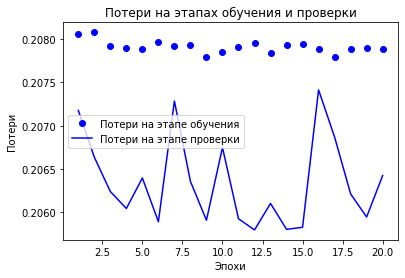

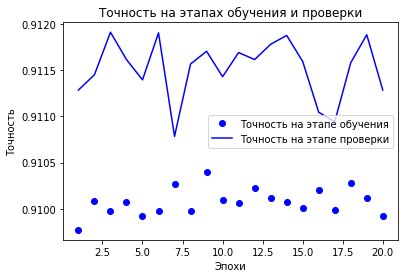

In [ ]:
# построение графика потери на этапах проверки и обучения
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy'])+1)

# построение графика потери на этапах проверки и обучения
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy'])+1)

plt.plot(epochs, loss_values, 'bo', label = 'Потери на этапе обучения')
plt.plot(epochs, val_loss_values, 'b', label = 'Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

# построение графика точности на этапах обучения и проверки
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label = 'Точность на этапе обучения')
plt.plot(epochs, val_acc_values, 'b', label = 'Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [ ]:
Y_pred=model.predict(x_test)
# задаем порог 0,5 для классификации текста
Y_pred=(Y_pred>=0.5).astype("int")
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test,Y_pred))
print(confusion_matrix(y_test,Y_pred))

4544/4544 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

       False       0.94      0.95      0.94    116310
        True       0.79      0.76      0.78     29067

    accuracy                           0.91    145377
   macro avg       0.86      0.86      0.86    145377
weighted avg       0.91      0.91      0.91    145377

[[110268   6042]
 [  6855  22212]]


# Адаптивный бустинг



In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
import torch as th

In [ ]:
th.cuda.is_available()

True

In [ ]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

In [17]:
x_train = [[tf] for tf in tfIdf_diff]

In [65]:
x_test = [[tf] for tf in tfIdf_diff_test]

In [61]:
Y = []
for j in range(5):
  Y.append([])
  # if j == 2:
  #   continue
  for i in range(len(y)):
    Y[j].append(y[i] == j)

In [62]:
modelClf = []
modelclf_fit = []
for i in range(5):
  # if i == 2:
  #   modelClf.append(None)
  #   modelclf_fit.append(None)
  #   continue
  modelClf.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42))

  X_train, X_valid, y_train, y_valid = train_test_split(x_train, Y[i], test_size = 0.5, random_state = 42)

  modelclf_fit.append(modelClf[i].fit(X_train, y_train))
  print(modelClf[i].score(X_valid, y_valid))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9219723246227323


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8052690359017197


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7998347467630341


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7986225870303448


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8206366789547279


In [ ]:
from sklearn import metrics

In [64]:
def predict_ab1(x):
  y_pred = []
  ochered = [0, 4, 1, 3, 2]
  for i in range(1, len(x) // 5 + 1):
    x_post = x[(i - 1) * 5 :i * 5]
    y_post = [-1, -1, -1, -1, -1]
    used = ochered.copy()
    j = 0
    step_count = 0
    max_step = 11
    while len(used) >= 1 and step_count < max_step:
      j += 1
      if j >= 5:
        j = 0
      #print(x_post)
      y_pred_post = modelclf_fit[used[j % len(used)]].predict(x_post)
      #print(y_pred_post)
      for k in range(len(y_pred_post)):
        if y_pred_post[k] == 1:
          kk = 0
          jj = 0
          while kk != k or y_post[jj] != -1:
            kk += (y_post[jj] == -1)
            jj += 1
          y_post[jj] = used[j % len(used)]
          x_post.pop(k)
          used.pop(j % len(used))
          j -= 1
          max_step -= 1
          break
      step_count += 1
    
    for j in range(5):
      if y_post[j] == -1:
        y_pred.append(used[0])
        used.pop(0)
      else:
        y_pred.append(y_post[j])
  return y_pred


In [ ]:
# x_test = th.Tensor(x_test)
# x_test = x_test.to(device)
# modelClf = th.Tensor(modelClf)
# modelClf = modelClf.to(device)
# modelclf_fit = th.Tensor(modelclf_fit)
# modelclf_fit = modelclf_fit.to(device)
# predict_ab = predict_ab.to(device)

In [ ]:
y_pred_test = predict_ab1(x_test)

In [67]:
y_pred = predict_ab1(x_train)

In [70]:
right = 0
for i in range(len(y_pred)):
  if y_pred[i] == y[i]:
    right += 1
print(right / len(y_pred))

0.43912


# Адаптивный бустинг с разделением по подмножествам

In [17]:
x_train = [[tf] for tf in tfIdf_diff]

In [ ]:
x_test = [[tf] for tf in tfIdf_diff_test]

In [18]:
def deleted_score(j, score):
  for i in range(5):
    if (j & (2 ** i)) and score == i:
      return False
  return True

In [28]:
print(len(x_train), len(y))

440535 440535


In [19]:
X = []
for j in range(0, 2 ** 5 - 1):
  X.append([])
  for k in range(len(x_train)):
    if (deleted_score(j, y[k])):
      X[j].append(x_train[k])

In [20]:
Y = []

for j in range(0, 2 ** 5 - 1):
  Y.append([])
  for i in range(5):
    Y[j].append([])
    for k in range(len(y)):
      if (deleted_score(j, y[k])):
        Y[j][i].append(y[k] == i)


In [44]:
modelClf2 = []
modelclf_fit2 = []
for j in range(0, 2 ** 5 - 1):
  modelClf2.append([])
  modelclf_fit2.append([])
  for i in range(5):
    # if i == 2:
    #   modelClf.append(None)
    #   modelclf_fit.append(None)
    #   continue
    modelClf2[j].append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42))

    X_train, X_valid, y_train, y_valid = train_test_split(X[j], Y[j][i], test_size = 0.3, random_state = 42)

    modelclf_fit2[j].append(modelClf2[j][i].fit(X_train, y_train))
    print(modelClf2[j][i].score(X_valid, y_valid))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9219663894794985


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8049424565492089


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7989724654020475


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7978980183261325


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8209078321138611


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8329881111142639


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7513643371260487


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.748621475659469


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7744516641602588


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9575234798399682


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7669040660556706


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7486025593734926


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7758325530365368


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7310238722776398


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6653089019761151


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7019811594385664


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9055604422627661


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8059851128829366


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.748621475659469


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7952784950202877


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8579391401944588


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6648296909088616


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7305068287577083


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9723318662748907


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7160043885645107


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7383381464620351


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.606734134115199


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.606734134115199


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9029878273699742


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7640760813021972


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7486025593734926


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8540513955489979


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7921485049875784


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6653593452463523


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8087065084429423


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.946366192920287


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7739132627968272


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8256428364250854


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.737085027901258


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.737085027901258


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8738287703191798


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7935861381893388


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9157345170687415


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8761373309372931


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8761373309372931


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9793625271919039


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9793625271919039
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9023825062187291


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7591105562333892


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7486403919454454


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7999697339424378


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7789071465503109


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6653719560639116


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7366356860915293


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9437431428679521


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7138227171267514


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7607349584473562


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6390617610895678


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6390617610895678


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8736774405084682


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.75180649961537


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8712435527195228


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8113118320249693


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8113118320249693


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9618840442636906


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9618840442636906


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8686709459374251


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6870121189956745


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7924763862441202


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6962829849616948


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6962829849616948


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.920230776506195


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.920230776506195


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8115766575238816


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8115766575238816


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1.0
1.0
1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [57]:
def predict_ab2(x):
  y_pred = []
  ochered = [0, 4, 1, 3, 2]
  for i in range(1, len(x) // 5 + 1):
    x_post = x[(i - 1) * 5 :i * 5]
    y_post = [-1, -1, -1, -1, -1]
    used = ochered.copy()
    j = 0
    step_count = 0
    max_step = 11
    deleted = 0
    while len(used) > 0 and step_count < max_step:
      j += 1
      if j >= 5:
        j = 0
      #print(x_post)
      #print(deleted, len(used))
      y_pred_post = modelclf_fit2[deleted][used[j % len(used)]].predict(x_post)
      #print(y_pred_post)
      for k in range(len(y_pred_post)):
        if y_pred_post[k] == 1:
          kk = 0
          jj = 0
          deleted += 2 ** used[j % len(used)]
          while kk != k or y_post[jj] != -1:
            kk += (y_post[jj] == -1)
            jj += 1
          y_post[jj] = used[j % len(used)]
          x_post.pop(k)
          used.pop(j % len(used))
          j -= 1
          max_step -= 1
          break
      step_count += 1
    
    for j in range(5):
      if y_post[j] == -1:
        y_pred.append(used[0])
        used.pop(0)
      else:
        y_pred.append(y_post[j])
  return y_pred

In [50]:
y_pred_test = predict_ab2(x_test)

In [58]:
y_pred_train = predict_ab2(x_train)

In [59]:
right = 0
for i in range(len(y_pred_train)):
  if y_pred_train[i] == y[i]:
    right += 1
print(right / len(y_pred_train))

0.48044


In [51]:
ii = 0
for i in range(len(ranking_test)):
  for j in range(len(ranking_test.iloc[i]["comments"])):
    ranking_test.iloc[i]["comments"][j]["score"] = y_pred_test[ii]
    ii += 1

In [52]:
json_train = ranking_test.to_json(orient='records', lines = True)
with open('/content/drive/MyDrive/Hack_DS/test_data2.jsonl', 'w') as f:
 f.write(json_train)